# Convolutional Layer Visual Analysis

### Introduction

前面的一些章节中，我们把 CNN 的 Conv layer weights 展示为图片，不过我们从中并无法看出什么头绪。本章我们换个思路，不会绘制 weights 的图片，而是通过调整原始输入图片来最大化某个 Conv layer 的 feature，也就是说看看什么样的输入图片能够最大化目的 feature，那么这个输入图片一定也代表了对应 Conv Layer feature 的一些特征。具体方法是随机初始化一个输入图片为噪声图，然后针对目标 feature 应用其对输入图片的 gradient，来逐步调整输入图片，看看最后能得到什么！这个方法称为 *feature maximization* 或 *activation maximization*。我们将使用 Inception model 为基础，去探索其 Conv Layer feature 的特性

### Flowchart

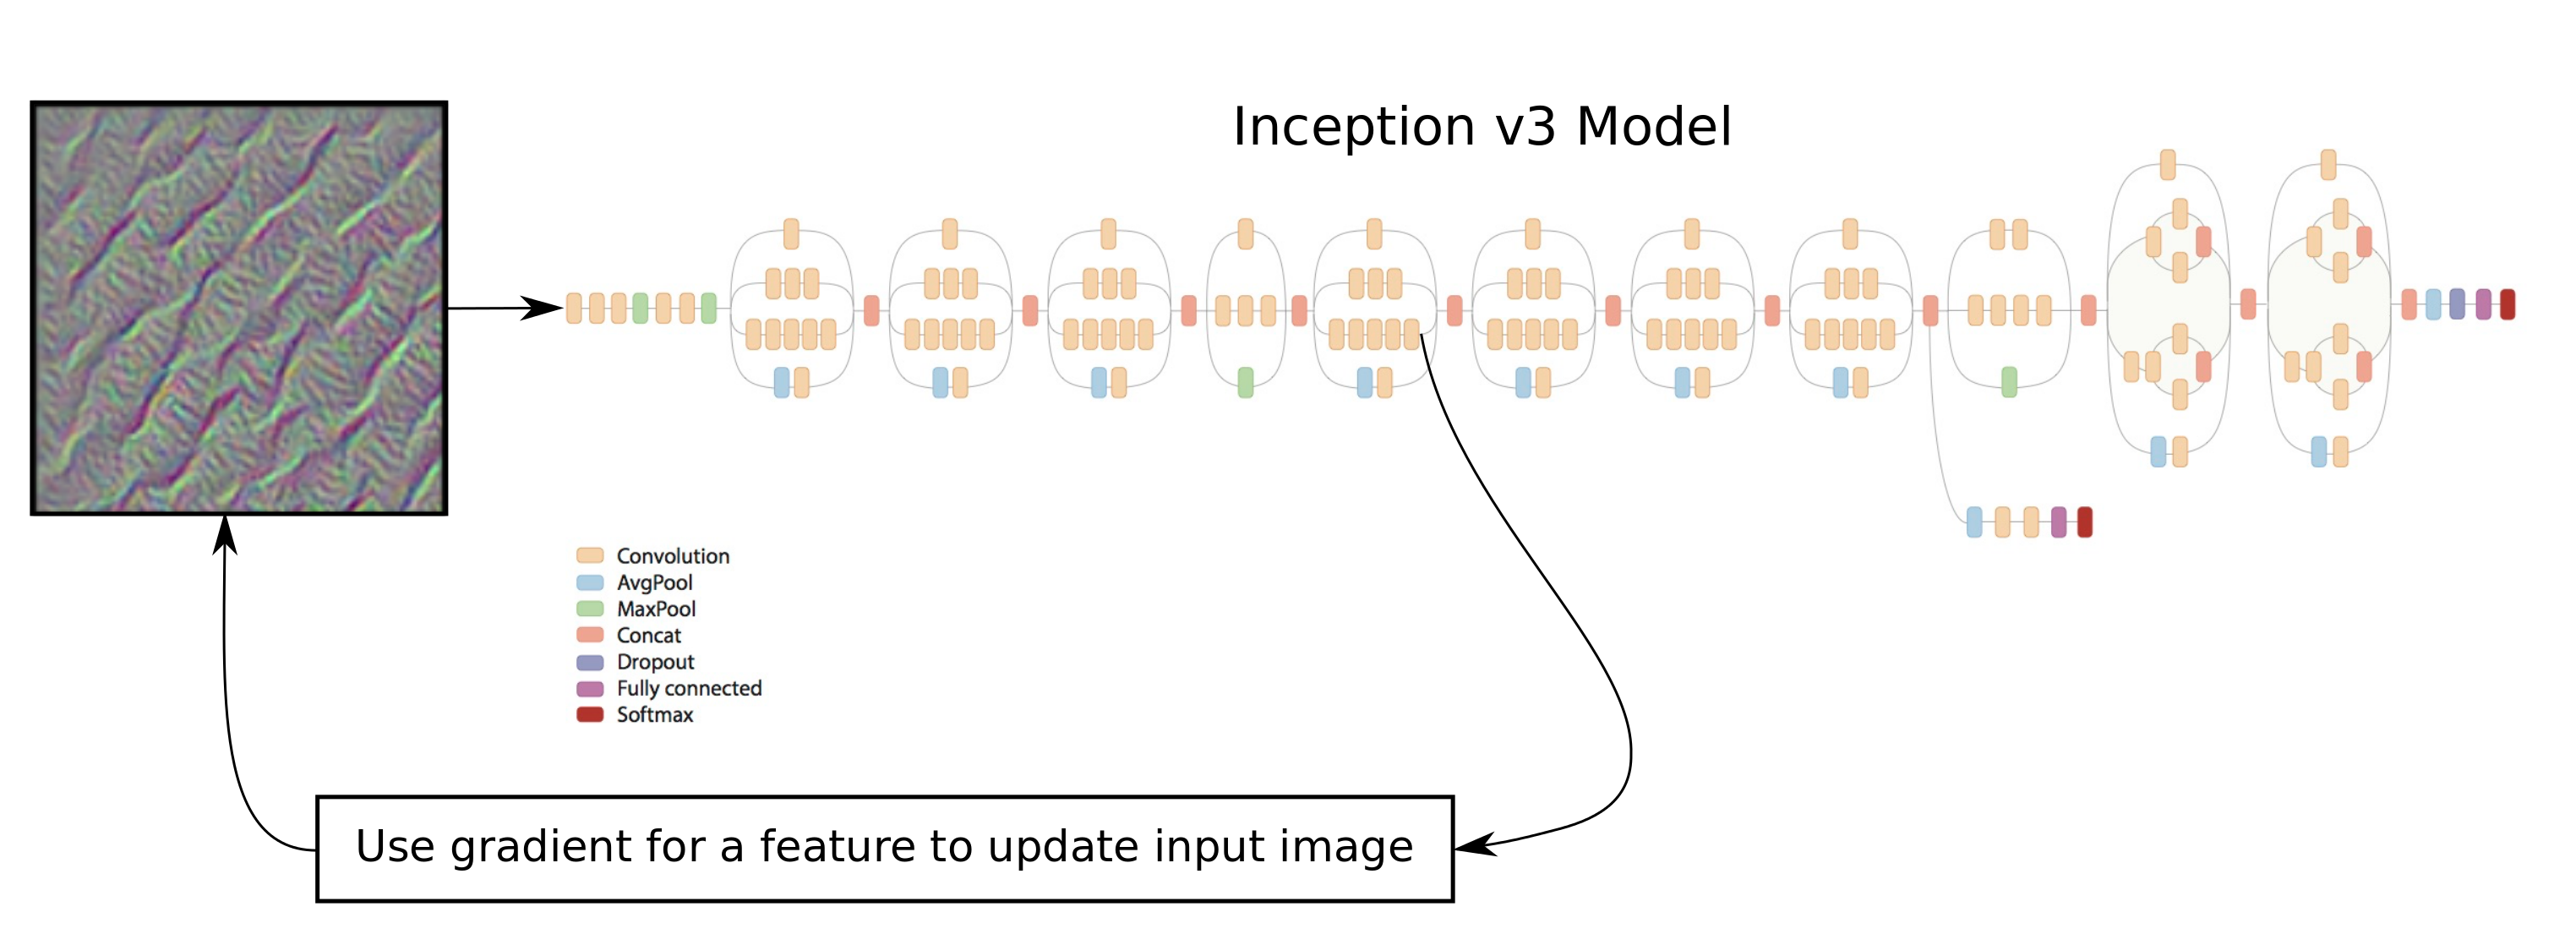

In [1]:
from IPython.display import Image, display
Image('images/13_visual_analysis_flowchart.png')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import inception

In [3]:
tf.__version__

'0.9.0'

### Inception Model

In [4]:
# inception.data_dir = 'inception/'
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


##### 获取 convolutional layers 的变量名

In [5]:
def get_conv_layer_names():
    model = inception.Inception()
    names = [op.name for op in model.graph.get_operations() if op.type=='Conv2D']
    model.close()
    return names

In [6]:
conv_names = get_conv_layer_names()

In [7]:
# Conv Layers 非常之多
len(conv_names)

94

In [8]:
# 随便看看几个
conv_names[:5]

[u'conv/Conv2D',
 u'conv_1/Conv2D',
 u'conv_2/Conv2D',
 u'conv_3/Conv2D',
 u'conv_4/Conv2D']

In [9]:
conv_names[-5:]

[u'mixed_10/tower_1/conv/Conv2D',
 u'mixed_10/tower_1/conv_1/Conv2D',
 u'mixed_10/tower_1/mixed/conv/Conv2D',
 u'mixed_10/tower_1/mixed/conv_1/Conv2D',
 u'mixed_10/tower_2/conv/Conv2D']

### 核心逻辑代码以及一些辅助函数

下面的函数是核心逻辑实现函数，用于优化最大化某个 feature 的输入图片。输入图片被初始化为随机 noise，然后通过 gradient descent 迭代的更新，目标是最大化 feature

In [22]:
def optimize_image(conv_id=None, feature=0,
                   num_iterations=30, show_progress=True):
    """
    Parameters:
    conv_id: Integer 类型，指定目标 Conv Layer，如果 None，则代表最后 softmax 输出之前的那个 fully-connected layer
    feature: Integer 类型，指定目标 layer 的哪个 feature
    """
    model = inception.Inception()
    resized_image = model.resized_image    # 输入图片需要调整为 299 x 299  model.graph.get_tensor_by_name("ResizeBilinear:0"）
    y_pred = model.y_pred                  # 输出预测 model.graph.get_tensor_by_name("softmax:0"）

    # 这里需要重新设计一个 loss func，用于对输入图片做 gradient descent
    if conv_id is None:
        # 对于 FC 层，指定 loss 为 softmax 结果
        loss = model.y_logits[0, feature]    # model.graph.get_tensor_by_name("softmax/logits:0") 
    else:
        # 对于 Conv 层，我们需要让 feature 最大化
        conv_name = conv_names[conv_id]     # conv_id 参数是指上面获取的 94 个 Conv 层的 index
        tensor = model.graph.get_tensor_by_name(conv_name + ":0")     # 通过 conv_name 构造变量，并获取对应的张量

        # 设置 default graph，以便我们可以在里面加入 ops
        with model.graph.as_default():
            # 指定 loss func 为指定 feature 对应的 weights 的平均值
            loss = tf.reduce_mean(tensor[:,:,:,feature])    # Conv 层为 input_channels, size(w x h), features； feature 是 features 的 index
    
    # 有了输入，有了 loss，我们保持 Inception model 自身的各层 weights ，biases 不变，使用 gradient 针对 loss 来优化输入
    gradient = tf.gradients(loss, resized_image)

    session = tf.Session(graph=model.graph)
    
    image_shape = resized_image.get_shape()
    image = np.random.uniform(size=image_shape) + 128.0      # 初始化，Inception model 输入图片像素范围为 0~255，故此在均值 128 周围取随机数

    for i in range(num_iterations):
        feed_dict = {model.tensor_name_resized_image: image}    # 直接从 resized_image 出发，因为初始化的就是 299 x 299 的图片，不需要再 resize 了
        pred = session.run(y_pred, feed_dict=feed_dict)
        loss_value = session.run(loss, feed_dict=feed_dict)
        grad = session.run(gradient, feed_dict=feed_dict)
        
        grad = np.array(grad).squeeze()    # 初始化的就只有一张图片，故此 batch_size 为 1；这里二维转一维
        # 来计算更新输入图片的 step size
        step_size = 1.0 / (grad.std() + 1e-8)    # 1e-8 for zero std(), 防止 divided by zero
        image += step_size * grad                # 更新输入图片，注意这里使用 +=，这是因为我们希望 loss 最大化，而不是最小化
        image = np.clip(image, 0.0, 255.0)

        if show_progress:
            print("Iteration:", i)
            
            # 找到此时输入图片预测最接近的分类，这算是 feature 的一个特征
            pred = np.squeeze(pred)
            pred_cls = np.argmax(pred)
            cls_name = model.name_lookup.cls_to_name(pred_cls, only_first_name=True)
            cls_score = pred[pred_cls]
            msg = "Predicted class-name: {0} (#{1}), score: {2:>7.2%}"
            print(msg.format(cls_name, pred_cls, cls_score))

            # 展示此时的 gradient 统计
            msg = "Gradient min: {0:>9.6f}, max: {1:>9.6f}, stepsize: {2:>9.2f}"
            print(msg.format(grad.min(), grad.max(), step_size))

            # 展示此时的 loss ，应该是越来越大才对
            print("Loss:", loss_value)

            # Newline.
            print()

    model.close()
    return image.squeeze()    # 最后返回优化好的图片

##### 辅助函数展示图片和噪声

In [11]:
def normalize_image(x):
    x_min = x.min()
    x_max = x.max()
    # 正规化到 0~1
    x_norm = (x - x_min) / (x_max - x_min)
    return x_norm

In [12]:
def plot_image(image):
    img_norm = normalize_image(image)
    plt.imshow(img_norm, interpolation='nearest')
    plt.show()

In [13]:
# 绘制 6 个图片
def plot_images(images, show_size=100):
    fig, axes = plt.subplots(2, 3)
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    smooth = True
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # 只显示一部分
        img = images[i, 0:show_size, 0:show_size, :]
        
        img_norm = normalize_image(img)
        ax.imshow(img_norm, interpolation=interpolation)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()    

##### 最后，流程化

这个函数对同一个 Conv 层选择前 6 个 features 进行优化，并绘制结果图片

In [14]:
def optimize_images(conv_id=None, num_iterations=30, show_size=100):
    if conv_id is None:
        print("Final fully-connected layer before softmax.")
    else:
        print("Layer:", conv_names[conv_id])

    images = []
    for feature in range(1,7):
        print("Optimizing image for feature no.", feature)
        image = optimize_image(conv_id=conv_id, feature=feature, show_progress=False, num_iterations=num_iterations)
        image = image.squeeze()
        images.append(image)

    images = np.array(images)
    plot_images(images=images, show_size=show_size)

### 运行和结果展示

##### 优化一个靠前的 Conv Layer

In [23]:
image = optimize_image(conv_id=5, feature=2,      # 第 6 个 Conv 层，第二个 feature
                       num_iterations=30, show_progress=True)

('Iteration:', 0)
Predicted class-name: dishwasher (#667), score:   5.19%
Gradient min: -0.000094, max:  0.000101, stepsize:  75999.01
('Loss:', 4.8378043)
()
('Iteration:', 1)
Predicted class-name: kite (#397), score:  12.22%
Gradient min: -0.000114, max:  0.000119, stepsize:  72459.44
('Loss:', 5.5905647)
()
('Iteration:', 2)
Predicted class-name: wall clock (#524), score:   5.64%
Gradient min: -0.000108, max:  0.000118, stepsize:  80312.47
('Loss:', 6.9104614)
()
('Iteration:', 3)
Predicted class-name: envelope (#879), score:   5.51%
Gradient min: -0.000117, max:  0.000132, stepsize:  87256.10
('Loss:', 7.9056578)
()
('Iteration:', 4)
Predicted class-name: syringe (#531), score:   5.65%
Gradient min: -0.000100, max:  0.000155, stepsize:  95097.30
('Loss:', 8.8576918)
()
('Iteration:', 5)
Predicted class-name: syringe (#531), score:  15.02%
Gradient min: -0.000093, max:  0.000096, stepsize: 103328.14
('Loss:', 9.710495)
()
('Iteration:', 6)
Predicted class-name: syringe (#531), score

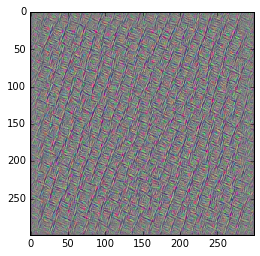

In [24]:
plot_image(image)

##### 优化多个 Conv 层的 features

('Layer:', u'conv/Conv2D')
('Optimizing image for feature no.', 1)
('Optimizing image for feature no.', 2)
('Optimizing image for feature no.', 3)
('Optimizing image for feature no.', 4)
('Optimizing image for feature no.', 5)
('Optimizing image for feature no.', 6)


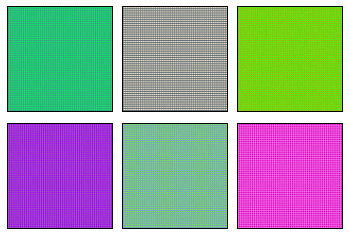

In [25]:
optimize_images(conv_id=0, num_iterations=10)      # 第一个 conv 层的 6 个 features

看到，这 6 个 features 非常之简单

('Layer:', u'conv_3/Conv2D')
('Optimizing image for feature no.', 1)
('Optimizing image for feature no.', 2)
('Optimizing image for feature no.', 3)
('Optimizing image for feature no.', 4)
('Optimizing image for feature no.', 5)
('Optimizing image for feature no.', 6)


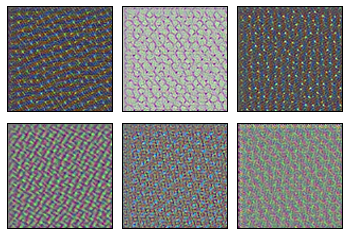

In [26]:
optimize_images(conv_id=3, num_iterations=30)    # 第 4 个 Conv 层

('Layer:', u'conv_4/Conv2D')
('Optimizing image for feature no.', 1)
('Optimizing image for feature no.', 2)
('Optimizing image for feature no.', 3)
('Optimizing image for feature no.', 4)
('Optimizing image for feature no.', 5)
('Optimizing image for feature no.', 6)


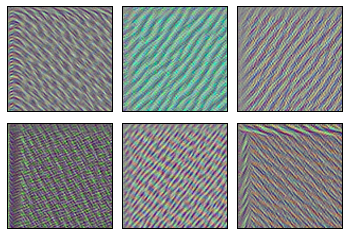

In [27]:
optimize_images(conv_id=4, num_iterations=30)

看到，越来越复杂，而且不同 features 对应的初始图片确实各不相同

('Layer:', u'mixed/tower/conv_1/Conv2D')
('Optimizing image for feature no.', 1)
('Optimizing image for feature no.', 2)
('Optimizing image for feature no.', 3)
('Optimizing image for feature no.', 4)
('Optimizing image for feature no.', 5)
('Optimizing image for feature no.', 6)


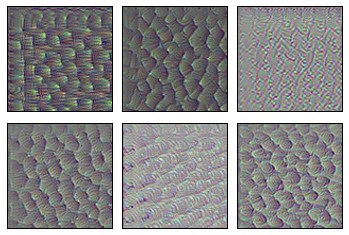

In [28]:
optimize_images(conv_id=7, num_iterations=30)

('Layer:', u'mixed/tower_1/conv_1/Conv2D')
('Optimizing image for feature no.', 1)
('Optimizing image for feature no.', 2)
('Optimizing image for feature no.', 3)
('Optimizing image for feature no.', 4)
('Optimizing image for feature no.', 5)
('Optimizing image for feature no.', 6)


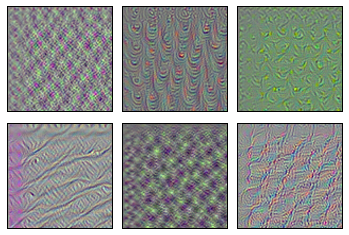

In [29]:
optimize_images(conv_id=9, num_iterations=30)

('Layer:', u'mixed_2/tower/conv/Conv2D')
('Optimizing image for feature no.', 1)
('Optimizing image for feature no.', 2)
('Optimizing image for feature no.', 3)
('Optimizing image for feature no.', 4)
('Optimizing image for feature no.', 5)
('Optimizing image for feature no.', 6)


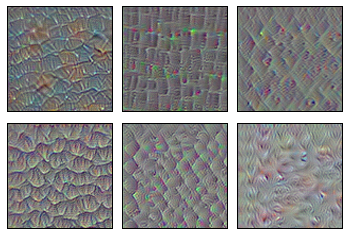

In [30]:
optimize_images(conv_id=20, num_iterations=30)

('Layer:', u'mixed_6/conv/Conv2D')
('Optimizing image for feature no.', 1)
('Optimizing image for feature no.', 2)
('Optimizing image for feature no.', 3)
('Optimizing image for feature no.', 4)
('Optimizing image for feature no.', 5)
('Optimizing image for feature no.', 6)


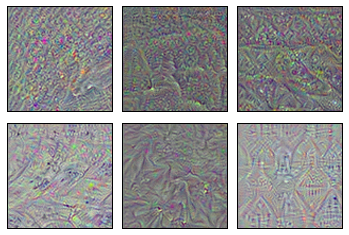

In [31]:
optimize_images(conv_id=50, num_iterations=30)

('Layer:', u'mixed_10/tower_1/conv_1/Conv2D')
('Optimizing image for feature no.', 1)
('Optimizing image for feature no.', 2)
('Optimizing image for feature no.', 3)
('Optimizing image for feature no.', 4)
('Optimizing image for feature no.', 5)
('Optimizing image for feature no.', 6)


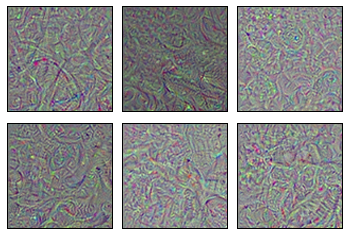

In [32]:
optimize_images(conv_id=90, num_iterations=30)

##### 看看最后的 fully-connected layer

Final fully-connected layer before softmax.
('Optimizing image for feature no.', 1)
('Optimizing image for feature no.', 2)
('Optimizing image for feature no.', 3)
('Optimizing image for feature no.', 4)
('Optimizing image for feature no.', 5)
('Optimizing image for feature no.', 6)


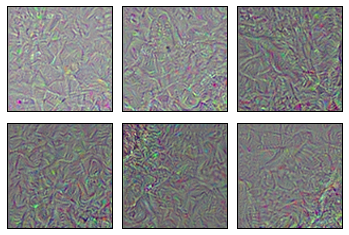

In [33]:
optimize_images(conv_id=None, num_iterations=30)

对第一个 feature 优化 100 步看看有何不同

In [34]:
image = optimize_image(conv_id=None, feature=1,
                       num_iterations=100, show_progress=True)

('Iteration:', 0)
Predicted class-name: dishwasher (#667), score:   5.53%
Gradient min: -0.005754, max:  0.004421, stepsize:   3639.07
('Loss:', -0.8159886)
()
('Iteration:', 1)
Predicted class-name: dishwasher (#667), score:  15.24%
Gradient min: -0.005620, max:  0.006405, stepsize:   2586.96
('Loss:', -1.2856318)
()
('Iteration:', 2)
Predicted class-name: spider web (#600), score:  36.21%
Gradient min: -0.006606, max:  0.005883, stepsize:   2340.00
('Loss:', 1.0268734)
()
('Iteration:', 3)
Predicted class-name: spider web (#600), score:  36.06%
Gradient min: -0.008838, max:  0.010050, stepsize:   1460.74
('Loss:', 3.8248606)
()
('Iteration:', 4)
Predicted class-name: kit fox (#1), score:  10.69%
Gradient min: -0.006563, max:  0.006004, stepsize:   2217.05
('Loss:', 6.1280928)
()
('Iteration:', 5)
Predicted class-name: spider web (#600), score:  11.46%
Gradient min: -0.009495, max:  0.008991, stepsize:   1619.81
('Loss:', 4.1112361)
()
('Iteration:', 6)
Predicted class-name: spider we

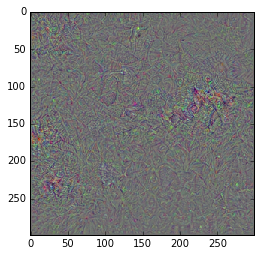

In [35]:
plot_image(image=image)